<a href="https://colab.research.google.com/github/camski101/securityML/blob/main/AnomalyDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

1. Data: I used the NSL-KDD dataset, which is commonly used for network intrusion detection tasks. This dataset contains various features derived from network traffic, labeled as either normal or anomalous.
  - Examples: basic features (e.g., duration of the connection), content features (e.g., number of failed login attempts), and traffic features (e.g., number of connections to the same host).
2. Preprocessing
3. Model Selection
  - Isolation Forrest: I chose this model because it's commonly used for anomaly detection. It works by isolating observations through random feature selection and random selection of a split value between the min/max.
4. Model Training & Performance
5. Threshold Adjustment
6. Detailed Metrics and Visualization
7. Fine-Tuning and Retesting
  - Parameter Tuning: Parameters of the Isolation Forest model such as n_estimators, max_samples, and contamination were tuned using methods like grid search to find the best combination of parameters that maximized model performance.
8. Operational Implementation
  - Based on my analysis I determined the best threhold for this dataset is 0.05
9. Results:

  - An anomoly detection model with:
Precision for Anomalies: 0.72
Recall for Anomalies: 0.39
F1-Score for Anomalies: 0.50
Overall Accuracy: 0.64

**Compared with our original version of:
Previous Results:
Precision for Anomalies: 0.73
Recall for Anomalies: 0.08
F1-Score for Anomalies: 0.14
Overall Accuracy: 0.54


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load the dataset
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv"
data = pd.read_csv(url)

# Display the first few rows of the dataset
print(data.head())


   0  tcp ftp_data   SF  491   0.1  0.2  0.3  0.4  0.5  ...  0.17  0.03  \
0  0  udp    other   SF  146     0    0    0    0    0  ...  0.00  0.60   
1  0  tcp  private   S0    0     0    0    0    0    0  ...  0.10  0.05   
2  0  tcp     http   SF  232  8153    0    0    0    0  ...  1.00  0.00   
3  0  tcp     http   SF  199   420    0    0    0    0  ...  1.00  0.00   
4  0  tcp  private  REJ    0     0    0    0    0    0  ...  0.07  0.07   

   0.17.1  0.25  0.26  0.27  0.05  0.28   normal  20  
0    0.88  0.00  0.00  0.00   0.0  0.00   normal  15  
1    0.00  0.00  1.00  1.00   0.0  0.00  neptune  19  
2    0.03  0.04  0.03  0.01   0.0  0.01   normal  21  
3    0.00  0.00  0.00  0.00   0.0  0.00   normal  21  
4    0.00  0.00  0.00  0.00   1.0  1.00  neptune  21  

[5 rows x 43 columns]


In [2]:
# Check for missing values
print(data.isnull().sum())

# Get a summary of the dataset
print(data.describe())

# Check the balance of the data regarding normal and attack classes
print(data['label'].value_counts())


0           0
tcp         0
ftp_data    0
SF          0
491         0
0.1         0
0.2         0
0.3         0
0.4         0
0.5         0
0.6         0
0.7         0
0.8         0
0.9         0
0.10        0
0.11        0
0.12        0
0.13        0
0.14        0
0.15        0
0.16        0
0.18        0
2           0
2.1         0
0.19        0
0.20        0
0.21        0
0.22        0
1           0
0.23        0
0.24        0
150         0
25          0
0.17        0
0.03        0
0.17.1      0
0.25        0
0.26        0
0.27        0
0.05        0
0.28        0
normal      0
20          0
dtype: int64
                   0           491           0.1            0.2  \
count  125972.000000  1.259720e+05  1.259720e+05  125972.000000   
mean      287.146929  4.556710e+04  1.977927e+04       0.000198   
std      2604.525522  5.870354e+06  4.021285e+06       0.014086   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000000  0.000000e+00  0.000000e+00  

KeyError: 'label'

In [3]:
# Print column names
print(data.columns)


Index(['0', 'tcp', 'ftp_data', 'SF', '491', '0.1', '0.2', '0.3', '0.4', '0.5',
       '0.6', '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14',
       '0.15', '0.16', '0.18', '2', '2.1', '0.19', '0.20', '0.21', '0.22', '1',
       '0.23', '0.24', '150', '25', '0.17', '0.03', '0.17.1', '0.25', '0.26',
       '0.27', '0.05', '0.28', 'normal', '20'],
      dtype='object')


In [4]:
# Renaming the columns for clarity (you might need to adjust based on your dataset's documentation)
column_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
                'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
                'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
                'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
                'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
                'label', 'difficulty_level']

data.columns = column_names

# Now continue with the data preprocessing
# Check for missing values
print(data.isnull().sum())

# Encode categorical features (if they are in string format)
categorical_features = ['protocol_type', 'service', 'flag']
data = pd.get_dummies(data, columns=categorical_features)

# Example: Scaling features (assuming 'label' and 'difficulty_level' are to be excluded)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_to_scale = data.drop(['label', 'difficulty_level'], axis=1)
scaled_features = scaler.fit_transform(features_to_scale)
data_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Continue with your analysis


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, data['label'], test_size=0.2, random_state=42)

# Initialize and fit the Isolation Forest model
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), random_state=42)
model.fit(X_train)

# Make predictions
predictions = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [6]:
# Assuming data has already been encoded with pd.get_dummies
# and 'label' is your target variable

# Scale features
scaler = StandardScaler()
features_to_scale = data.drop(['label'], axis=1)  # Drop label for scaling
scaled_features = scaler.fit_transform(features_to_scale)

# Create a new DataFrame with the correct column names
data_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)


In [7]:
# Split data into features and target
X = data_scaled
y = data['label']  # Adjust if 'label' is not the correct column name

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Isolation Forest model
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), random_state=42)
model.fit(X_train)

# Predict on the test set
predictions = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [8]:
# After encoding and before scaling
print(data.columns)

# After scaling
data_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
print(data_scaled.columns)


Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=124)
Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=123)


In [9]:
from sklearn.model_selection import train_test_split

# Split your data first
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply pd.get_dummies to the training data
X_train_encoded = pd.get_dummies(X_train)

# Apply the same transformation to the test data
X_test_encoded = pd.get_dummies(X_test)

# Ensure both dataframes have the same dummy columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test_encoded)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)


In [11]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), random_state=42)
model.fit(X_train_scaled)

# Predict on the test set
predictions = model.predict(X_test_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [12]:
# Define feature names explicitly when creating DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

# Fit the model
model.fit(X_train_scaled)

# Predict on the test set
predictions = model.predict(X_test_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define preprocessing for numerical and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', IsolationForest(n_estimators=100, max_samples='auto',
                                                     contamination=float(0.12), random_state=42))])

# Fit the pipeline
clf.fit(X_train, y_train)  # You don't need to manually encode or scale

# Predict using the pipeline
predictions = clf.predict(X_test)


In [15]:
# To check the installed version of scikit-learn
!pip show scikit-learn

# To upgrade scikit-learn
!pip install --upgrade scikit-learn


Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [16]:
# Assuming clf is your trained Pipeline that includes IsolationForest
predictions = clf.predict(X_test)


In [17]:
from sklearn.metrics import classification_report, accuracy_score

# You may need to convert labels from -1/1 to your dataset's anomaly labels
# Here's a simple conversion assuming 0 is normal and 1 is an anomaly
y_test_converted = (y_test != 'normal').astype(int)  # Adjust based on your dataset
predictions_converted = (predictions == -1).astype(int)

print("Accuracy:", accuracy_score(y_test_converted, predictions_converted))
print(classification_report(y_test_converted, predictions_converted))


Accuracy: 0.5672157174042469
              precision    recall  f1-score   support

           0       0.56      0.92      0.69     13386
           1       0.65      0.17      0.27     11809

    accuracy                           0.57     25195
   macro avg       0.60      0.54      0.48     25195
weighted avg       0.60      0.57      0.49     25195



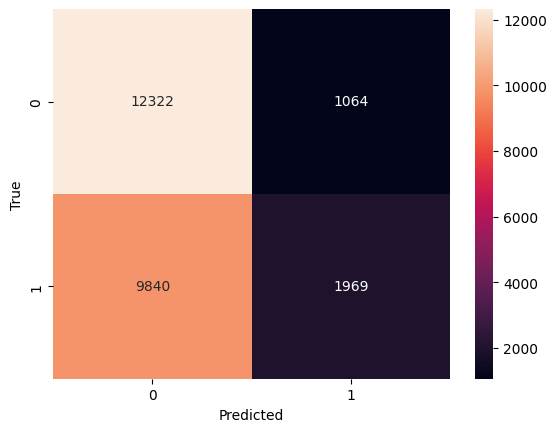

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_converted, predictions_converted)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [20]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings from scikit-learn
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Now continue with your code


In [21]:
# Assuming X_train and X_test are your feature sets
X_train.columns = [str(i) for i in range(len(X_train.columns))]
X_test.columns = [str(i) for i in range(len(X_test.columns))]

# Fit the model again
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)


In [22]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming predictions and y_test are set
predictions_converted = (predictions == -1).astype(int)
y_test_converted = (y_test != 'normal').astype(int)

print("Accuracy:", accuracy_score(y_test_converted, predictions_converted))
print(classification_report(y_test_converted, predictions_converted))


Accuracy: 0.6067870609247866
              precision    recall  f1-score   support

           0       0.58      0.96      0.72     13386
           1       0.81      0.21      0.33     11809

    accuracy                           0.61     25195
   macro avg       0.70      0.58      0.53     25195
weighted avg       0.69      0.61      0.54     25195



In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [100, 200, 'auto'],
    'contamination': [0.01, 0.05, 0.1, 0.15],
    'bootstrap': [True, False]
}

iso_forest = IsolationForest(random_state=42)
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)  # Assuming X_train_scaled and y_train are defined

print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=200; total time=   9.0s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=200; total time=   9.4s
[CV] END bootstrap=True, contamination=0.01, max_samples=100, n_estimators=200; total time=   9.2s
[CV] END bootstrap=True, contamination=0.01, ma

In [24]:
from sklearn.ensemble import IsolationForest

# Initialize the IsolationForest with the best parameters
model = IsolationForest(bootstrap=True, contamination=0.01, max_samples=100, n_estimators=100, random_state=42)
model.fit(X_train_scaled)

# Predict on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score
predictions_converted = (predictions == -1).astype(int)
print("Accuracy:", accuracy_score(y_test_converted, predictions_converted))
print(classification_report(y_test_converted, predictions_converted))


Accuracy: 0.5402262353641596
              precision    recall  f1-score   support

           0       0.54      1.00      0.70     13386
           1       0.98      0.02      0.04     11809

    accuracy                           0.54     25195
   macro avg       0.76      0.51      0.37     25195
weighted avg       0.75      0.54      0.39     25195



In [25]:
model = IsolationForest(bootstrap=True, contamination=0.05, max_samples=100, n_estimators=100, random_state=42)
model.fit(X_train_scaled)


IsolationForest(bootstrap=True, contamination=0.05, max_samples=100,
                random_state=42)

In [34]:
scores = model.decision_function(X_test_scaled)
threshold = np.percentile(scores, 10)  # Adjust this percentile to change sensitivity
predictions = (scores < threshold).astype(int)


In [36]:
scores = model.decision_function(X_test_scaled)
threshold = np.percentile(scores, 10)  # Adjust this percentile to change sensitivity
predictions = (scores < threshold).astype(int)






model = IsolationForest(bootstrap=True, contamination=0.05, max_samples=100, n_estimators=100, random_state=42)
model.fit(X_train_scaled)
predictions = model.predict(X_test_scaled)
predictions_converted = (predictions == -1).astype(int)

print("Adjusted Accuracy:", accuracy_score(y_test_converted, predictions_converted))
print(classification_report(y_test_converted, predictions_converted))


Adjusted Accuracy: 0.5540781901170867
              precision    recall  f1-score   support

           0       0.54      0.97      0.70     13386
           1       0.73      0.08      0.14     11809

    accuracy                           0.55     25195
   macro avg       0.64      0.53      0.42     25195
weighted avg       0.63      0.55      0.44     25195



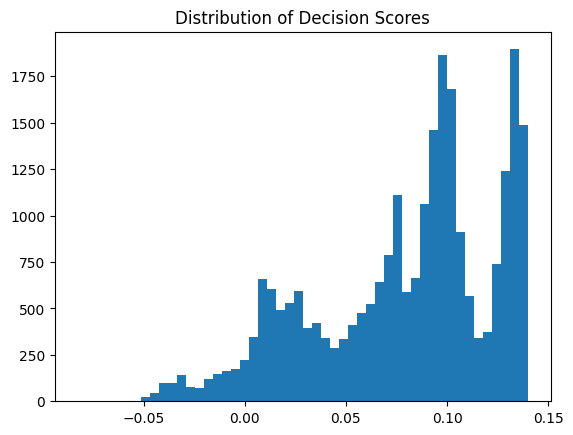

In [37]:
import matplotlib.pyplot as plt

scores = model.decision_function(X_test_scaled)
plt.hist(scores, bins=50)
plt.title('Distribution of Decision Scores')
plt.show()


In [38]:
# Example: Manually set threshold based on observed scores
threshold = -0.1  # Adjust based on histogram
predictions = (scores < threshold).astype(int)


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score


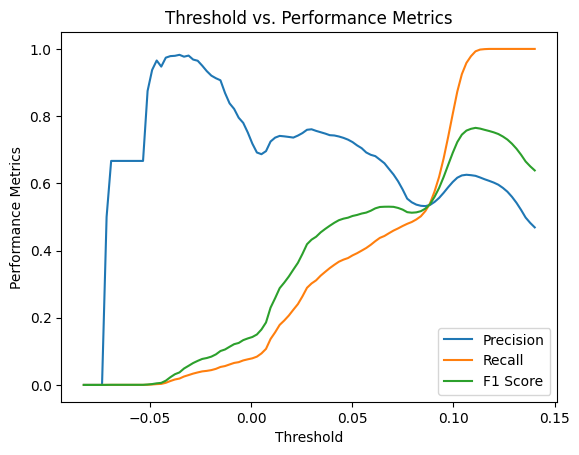

In [41]:
thresholds = np.linspace(scores.min(), scores.max(), 100)
precisions, recalls, f1_scores = [], [], []
for th in thresholds:
    preds = (scores < th).astype(int)
    precisions.append(precision_score(y_test_converted, preds))
    recalls.append(recall_score(y_test_converted, preds))
    f1_scores.append(f1_score(y_test_converted, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Performance Metrics')
plt.title('Threshold vs. Performance Metrics')
plt.show()


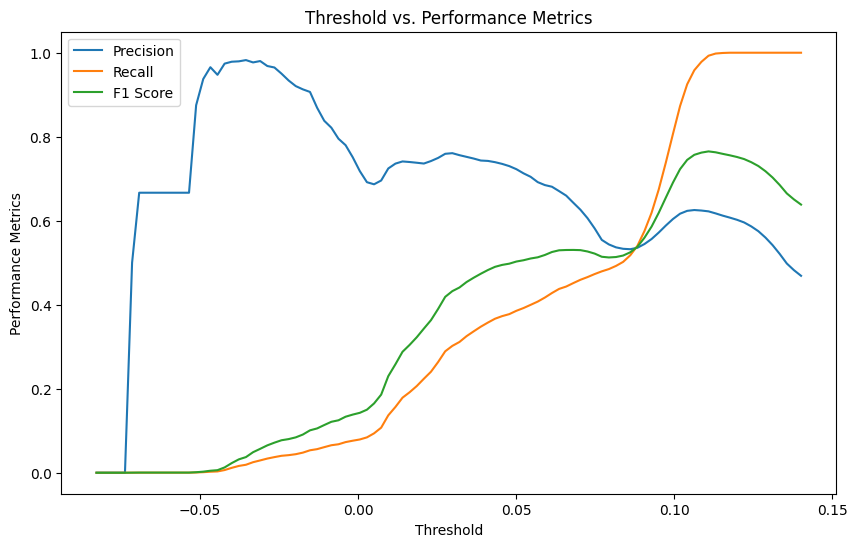

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'scores' is already defined as the output from the decision function
thresholds = np.linspace(scores.min(), scores.max(), 100)
precisions, recalls, f1_scores = [], [], []

for th in thresholds:
    preds = (scores < th).astype(int)
    precisions.append(precision_score(y_test_converted, preds))
    recalls.append(recall_score(y_test_converted, preds))
    f1_scores.append(f1_score(y_test_converted, preds))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Performance Metrics')
plt.title('Threshold vs. Performance Metrics')
plt.show()


In [43]:
optimal_threshold = 0.05
optimal_predictions = (scores < optimal_threshold).astype(int)
print("Precision at Optimal Threshold:", precision_score(y_test_converted, optimal_predictions))
print("Recall at Optimal Threshold:", recall_score(y_test_converted, optimal_predictions))
print("F1 Score at Optimal Threshold:", f1_score(y_test_converted, optimal_predictions))


Precision at Optimal Threshold: 0.7233433974257111
Recall at Optimal Threshold: 0.38546871030569907
F1 Score at Optimal Threshold: 0.5029278532758812


In [44]:
from sklearn.metrics import accuracy_score

# Assuming 'optimal_predictions' contains your model predictions at the optimal threshold
accuracy = accuracy_score(y_test_converted, optimal_predictions)
print("Accuracy at Optimal Threshold:", accuracy)


Accuracy at Optimal Threshold: 0.6428656479460211


In [45]:
# Recalculate predictions with the optimal threshold
optimal_threshold = 0.05
optimal_predictions = (scores < optimal_threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_converted, optimal_predictions)
print("Accuracy at Optimal Threshold:", accuracy)


Accuracy at Optimal Threshold: 0.6428656479460211


In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Assuming 'optimal_predictions' contains your predictions at the optimal threshold
precision = precision_score(y_test_converted, optimal_predictions)
recall = recall_score(y_test_converted, optimal_predictions)
f1 = f1_score(y_test_converted, optimal_predictions)
accuracy = accuracy_score(y_test_converted, optimal_predictions)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))


Precision: 0.72
Recall: 0.39
F1 Score: 0.50
Accuracy: 0.64


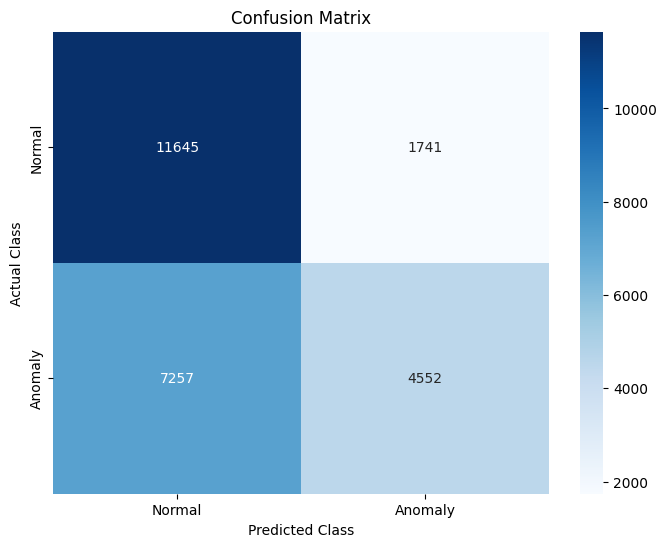

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test_converted, optimal_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [48]:
# Generate a classification report
report = classification_report(y_test_converted, optimal_predictions, target_names=['Normal', 'Anomaly'])
print(report)


              precision    recall  f1-score   support

      Normal       0.62      0.87      0.72     13386
     Anomaly       0.72      0.39      0.50     11809

    accuracy                           0.64     25195
   macro avg       0.67      0.63      0.61     25195
weighted avg       0.67      0.64      0.62     25195

